In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from LookaheadCQR.cqr_lookahead.uncertainty import CQR


from LookaheadCQR.lookahead.models.lookahead import Lookahead
import LookaheadCQR.lookahead.models.uncertainty as uncert
import LookaheadCQR.lookahead.models.prediction as pred
import LookaheadCQR.lookahead.models.propensity as prop
from LookaheadCQR.lookahead.models.models import polyRegression

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
np.set_printoptions(precision=3)

## Setting the data hyperparameters

In [2]:
# Random Seed
seed = 3

# Coefficients of the ground truth polynomial
# coeffs[i] denotes the coefficient of x^i th term
coeffs = [0.1, 0.5, -0.8]

# Number of Training Samples
n = 1000

# Our input is drawn from the normal distribution
# with std = sig and mean = offset
sig = 0.5
offset = -0.8

# std of noise added to the data
ns = 0.1

# Split ratio for train-test
trn_sz = 0.75

# Degree of polynomial regressor
degree = 2

## Defining the ground truth function f*

f1*(x) =  -0.8 x<sup>2</sup> + 0.5 x + 0.1

f2*(x) =  -0.8 sin(x) + 0.5 sin(x / 2) + 0.1

In [3]:
class Fstar_parabola():
    def __init__(self, coeffs = []):
        self.coeffs = coeffs
    def fit(self, x, y):
        pass
    def predict(self, x):
        c = self.coeffs[-1]
        for i in range(2, len(self.coeffs) + 1):
            c = self.coeffs[-i] + c*x
        return c.flatten()

class Fstar_sin():
    def __init__(self, coeffs = []):
        self.coeffs = coeffs
    def fit(self, x, y):
        pass
    def predict(self, x):
        c = self.coeffs[-1]
        for i in range(2, len(self.coeffs) + 1):
            c = self.coeffs[-i] + c*np.sin(x / (i - 1))
        return c.flatten()

class Fstar_exp():
    def __init__(self, coeffs = []):
        self.coeffs = coeffs
    def fit(self, x, y):
        pass
    def predict(self, x):
        c = self.coeffs[-1]
        for i in range(2, len(self.coeffs) + 1):
            c = self.coeffs[-i] + c*np.exp(x / (i - 1))
        return c.flatten()

In [4]:
np.random.seed(seed)

# Pick an f* function
fstar = Fstar_parabola(coeffs)

In [5]:
x = np.random.normal(size = (n, 1), scale = sig) + offset
y = fstar.predict(x)
y += np.random.normal(scale = ns, size = y.shape)

n, d = x.shape
x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, test_size = 1 - trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print("n:", n, ", n_trn:", n_trn, ", n_tst:", n_tst)
xs = [x_trn, x_tst, x]
ys = [y_trn, y_tst, y]

n: 1000 , n_trn: 750 , n_tst: 250


## Setting the model hyperparamters

In [6]:
# l1/l2 Regularization coefficient
alpha = 0.
# Lam controls the tradeoff between accuracy and decision improvement
lam = 4.

" Hyperparamteres for Lookahead"
# Decision step size
eta = 0.8
# Number of cycles for training
num_cycles = 10
# Z-score controls size of confidence intervas
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# Learning rate
lr_f = 0.05
# Number of training iterations
num_iter_init = 1000
num_iter_f = 100
num_iter_base = num_iter_init + num_iter_f*num_cycles

""" Hyperparameters for Uncertanity Model"""
#number of bootstrapped models
num_gs = 10
# Learning rate
lr_g = 0.001
# Number of training iterations
num_iter_g = 5000 #for training g in cycles

""" Mask"""
# mask[i] is 1 if it can be changed for making decisions
mask = np.ones(d)
print('mask:', mask)

mask: [1.]


In [7]:
# Helper functions to print performance
def get_perf(model, xs, ys, eta, mask, uncert=False):
    perf = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    perf['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    if uncert:
        xsp = [model.move_points(x_) for x_ in xs]
        perf['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf = {k:np.asarray(v) for k,v in zip(perf.keys(),perf.values())}
    return perf

def print_perf(perf, idx=0, uncert=False):
    print('\ttrn\ttst\tall')
    print(('mse'+'\t{:.4f}'*3).format(*perf['mse'][idx,:]))
    print(('mae'+'\t{:.4f}'*3).format(*perf['mae'][idx,:]))
    print(('imprv'+'\t{:.4f}'*3).format(*perf['improve'][idx,:]))
    print(('imprt'+'\t{:.4f}'*3).format(*perf['imprate'][idx,:]))
    print()
    if uncert:
        print('\ttrn\'\ttst\'\tall')
        print(('contn'+'\t{:.3f}'*3).format(*perf['contain'][idx,:]))
        print(('intrsz'+'\t{:.3f}'*3).format(*perf['size'][idx,:]))
        print()

## Training the baseline model with no lookahead regularization

In [8]:
# train baseline
verbose = True

print('training baseline:')
f_model = polyRegression(1, 1, degree)
f_base = pred.PredModel(d, model=f_model, reg_type='none', alpha=alpha, lr=lr_f, num_iter_init=num_iter_base)
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

perf_base = get_perf(model_base, xs, ys, eta, mask)
print_perf(perf_base)

training baseline:
t: 0
[f] mse: 0.0105, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0105
[f] improve*: 1.086

	trn	tst	all
mse	0.0105	0.0093	0.0102
mae	0.0823	0.0765	0.0808
imprv	1.0863	1.1010	1.0900
imprt	0.9707	0.9760	0.9720



## Training the paper's lookahead model

In [9]:
# train our model
verbose = True

print('Training lookahead:')
f_model = polyRegression(1, 1, degree)
g_model = polyRegression(1, 1, degree)

f = pred.PredModel(d, model = f_model, reg_type='none', alpha=0., lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
u = uncert.Bootstrap(d, model = g_model, alpha=0., num_gs=num_gs, z_score=z_score, lr=lr_g, num_iter=num_iter_g)
h = prop.PropModel(random_state=seed)
model = Lookahead(f, u, h, lam=lam, eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

Training lookahead:
t: 0
[f] mse: 0.0108, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0108
[f] improve*: 1.091

t: 1
[h] n_eff: 1.43, w_sum: 3110.46
[u] loss: 0.0031, norm_reg: 0.0000, obj: 0.0031
[u] size: 0.563, contain*: 1.000
[f] mse: 0.0339, la_reg: 0.0661, norm_reg: 0.0000, obj: 0.2984
[f] improve*: 0.956

t: 2
[h] n_eff: 1.55, w_sum: 452.80
[u] loss: 0.0040, norm_reg: 0.0000, obj: 0.0040
[u] size: 0.491, contain*: 1.000
[f] mse: 0.0419, la_reg: 0.0565, norm_reg: 0.0000, obj: 0.2680
[f] improve*: 0.950

t: 3
[h] n_eff: 1.55, w_sum: 542.11
[u] loss: 0.0040, norm_reg: 0.0000, obj: 0.0040
[u] size: 0.492, contain*: 0.989
[f] mse: 0.0488, la_reg: 0.0523, norm_reg: 0.0000, obj: 0.2579
[f] improve*: 0.941

t: 4
[h] n_eff: 1.56, w_sum: 800.42
[u] loss: 0.0041, norm_reg: 0.0000, obj: 0.0041
[u] size: 0.496, contain*: 0.899
[f] mse: 0.0547, la_reg: 0.0495, norm_reg: 0.0000, obj: 0.2529
[f] improve*: 0.930

t: 5
[h] n_eff: 1.58, w_sum: 1032.03
[u] loss: 0.0042, norm_reg: 0.0000, obj: 0.0042
[

## Training our CQR + lookahead model

In [10]:
# train our model
verbose = True

print('Training lookahead:')
f_model = polyRegression(1, 1, degree)

f = pred.PredModel(d, model = f_model, reg_type='none', alpha=0., lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
u = CQR(d, tau=(0.05, 0.95), lr=lr_g, num_iter=num_iter_g)
h = prop.PropModel(random_state=seed)
nn_cqr_model = Lookahead(f, u, h, lam=lam, eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = nn_cqr_model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

Training lookahead:
t: 0
[f] mse: 0.0108, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0108
[f] improve*: 1.091

t: 1
[h] n_eff: 1.43, w_sum: 3110.46
[u] loss: 0.0597, norm_reg: 0.0000, obj: 0.0597
[u] size: 0.967, contain*: 0.953
[f] mse: 0.0261, la_reg: 0.0173, norm_reg: 0.0000, obj: 0.0955
[f] improve*: 0.956

t: 2
[h] n_eff: 1.55, w_sum: 842.64
[u] loss: 0.0372, norm_reg: 0.0000, obj: 0.0372
[u] size: 1.293, contain*: 0.841
[f] mse: 0.0278, la_reg: 0.0453, norm_reg: 0.0000, obj: 0.2091
[f] improve*: 0.946

t: 3
[h] n_eff: 1.56, w_sum: 809.81
[u] loss: 0.0377, norm_reg: 0.0000, obj: 0.0377
[u] size: 1.323, contain*: 0.947
[f] mse: 0.0109, la_reg: 0.0771, norm_reg: 0.0000, obj: 0.3195
[f] improve*: 1.093

t: 4
[h] n_eff: 1.43, w_sum: 3176.23
[u] loss: 0.0352, norm_reg: 0.0000, obj: 0.0352
[u] size: 1.143, contain*: 1.000
[f] mse: 0.0219, la_reg: 0.0782, norm_reg: 0.0000, obj: 0.3348
[f] improve*: 1.159

t: 5
[h] n_eff: 1.36, w_sum: 11585.18
[u] loss: 0.0362, norm_reg: 0.0000, obj: 0.0362

## Comparing the performance of all models

In [11]:
perf_base = get_perf(model_base, xs, ys, eta, mask)
perf_la = get_perf(model, xs, ys, eta, mask, uncert=True)
perf_la_cqr = get_perf(nn_cqr_model, xs, ys, eta, mask, uncert=True)

print('\nBaseline Model:')
print_perf(perf_base)
print('Lookahead Model:')
print_perf(perf_la, uncert=True)
print('Lookahead+CQR Model:')
print_perf(perf_la_cqr, uncert=True)


Baseline Model:
	trn	tst	all
mse	0.0105	0.0093	0.0102
mae	0.0823	0.0765	0.0808
imprv	1.0863	1.1010	1.0900
imprt	0.9707	0.9760	0.9720

Lookahead Model:
	trn	tst	all
mse	0.0667	0.0486	0.0622
mae	0.1792	0.1603	0.1745
imprv	0.9058	0.9330	0.9126
imprt	0.7560	0.7680	0.7590

	trn'	tst'	all
contn	0.761	0.772	0.764
intrsz	0.506	0.508	0.507

Lookahead+CQR Model:
	trn	tst	all
mse	0.0647	0.0630	0.0643
mae	0.2024	0.2003	0.2019
imprv	1.1785	1.1948	1.1825
imprt	0.9707	0.9760	0.9720

	trn'	tst'	all
contn	1.000	1.000	1.000
intrsz	0.757	0.759	0.759



## Plotting the results
The main plot shows the predictions generated by the lookahead model.  The inlay plot shows the performance of the baseline classifier

In [12]:
# Helper function for plotting
def plot_quad(ax, M, x, y, x_plot, y_plot, eta, mask, color, lw=1, osz=50, olw=1,
              fill_between_color = 'g'):
    x_plot_th = torch.from_numpy(x_plot.astype(np.float32))
    ax.plot(x_plot, y_plot, '--', color="tab:orange", linewidth =1.0, label ="gt", alpha=0.6)

    f_pred = M.f.predict(x_plot)
    ax.plot(x_plot, f_pred, label="f", linewidth=lw, alpha=0.6)

    if M.u is not None:
        u_pred, l_pred = M.u.lu(x_plot_th)
        u_pred = u_pred.detach().numpy()
        l_pred = l_pred.detach().numpy()
        ax.fill_between(x_plot.flatten(), u_pred.flatten(), l_pred.flatten(),
                        color=fill_between_color, alpha=0.05, zorder=0)
        ax.plot(x_plot.flatten(), u_pred.flatten(), f"tab:{color}", linewidth=1.0, alpha=0.5, zorder=0)
        ax.plot(x_plot.flatten(), l_pred.flatten(), f"tab:{color}", linewidth=1.0, alpha=0.5, zorder=0)

    xp = M.move_points(x, eta, mask)
    ypstar = M.fstar.predict(xp)
    ax.scatter(x, y, color="white", edgecolor="tab:blue", alpha = 1, s=osz, zorder=10, linewidth=olw)
    ax.scatter(xp, ypstar, color="white", edgecolor="tab:red", alpha = 1, s=osz, zorder=10, linewidth=olw)

    ax.set_xticks([])
    ax.set_yticks([])

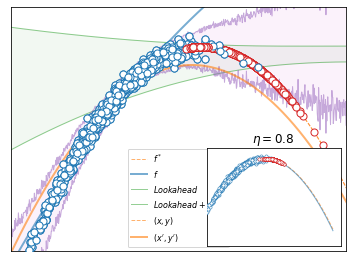

In [13]:
plt.rcParams['figure.figsize'] = (6.0, 4.5)
x_plot = np.linspace(-3.0, 3.0, 1000)[:, np.newaxis]
y_plot = fstar.predict(x_plot)

ax = plt.axes()
axins = inset_axes(ax, width="40%", height="40%", loc=4)
plot_quad(axins, model_base, x, y, x_plot, y_plot, eta, mask, osz=10, olw=0.5,
          color='green')
axins.set_xlim([-2, 3.3])
axins.set_ylim([-7, 1.0])

plot_quad(ax, model, x, y, x_plot, y_plot, eta, mask, lw=2, color='green')
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-4, 1])
plt.title(r'$\eta={}$'.format(eta))

plot_quad(ax, nn_cqr_model, x, y, x_plot, y_plot, eta, mask, lw=2, color='purple',
          fill_between_color='m')
ax.set_xlim([-2.2, 2.2])
ax.set_ylim([-4, 1])
plt.title(r'$\eta={}$'.format(eta))

ax.legend(
    [
        r'$f^*$',
        r'$f$',
        r'$Lookahead$',
        r'$Lookahead + CQR$',
        r'$(x,y)$',
        r"$(x',y')$"
    ],
    fontsize=8,
)
plt.show()